Note to myself
class method needs "return self" to enable cascading of methods like
grid.add_node().add_node().add_node()

In [1]:
pwd

'/mnt/home/kipnis/making_structural_alphabet/scripts'

In [1]:
import sys
sys.path.append("/home/kipnis/scripts")
print(sys.path)

['/mnt/home/arielb10/projects/rlProtGen/nb', '/home/arielb10/.conda/envs/rlProtGen/lib/python37.zip', '/home/arielb10/.conda/envs/rlProtGen/lib/python3.7', '/home/arielb10/.conda/envs/rlProtGen/lib/python3.7/lib-dynload', '', '/home/arielb10/.conda/envs/rlProtGen/lib/python3.7/site-packages', '/home/arielb10/.conda/envs/rlProtGen/lib/python3.7/site-packages/IPython/extensions', '/mnt/home/arielb10/.ipython', '/home/kipnis/scripts']


In [4]:
import numpy as np
import math
import random
from random import randint, choice
from typing import List, Tuple, Optional, Union, Set, Dict, Any

import SimplePdbLib
from SimplePdbLib import *

from SimpleXyzMath3 import *

# spl = dir(SimplePdbLib)
# for i in spl:
#     if not i.startswith("__"): print(i) 

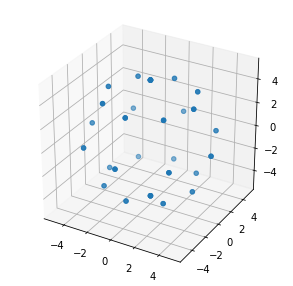

 5.0  0.0  0.0
 3.5  3.5  0.0
 0.0  5.0  0.0
-3.5  3.5  0.0
-5.0  0.0  0.0
-3.5 -3.5  0.0
-0.0 -5.0  0.0
 3.5 -3.5  0.0
 3.5  0.0  3.5
 2.5  2.5  3.5
 0.0  3.5  3.5
-2.5  2.5  3.5
-3.5  0.0  3.5
-2.5 -2.5  3.5
-0.0 -3.5  3.5
 2.5 -2.5  3.5
 0.0  0.0  5.0
-3.5 -0.0 -3.5
-2.5 -2.5 -3.5
-0.0 -3.5 -3.5
 2.5 -2.5 -3.5
 3.5 -0.0 -3.5
 2.5  2.5 -3.5
 0.0  3.5 -3.5
-2.5  2.5 -3.5
-0.0 -0.0 -5.0
Total:  26


In [4]:
#simple sphere visualization, to get directionality vectors of Vision26
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

step = 45
r0 = 5.0
xs = []
ys = []
zs = []
for i in range(0,360,step):
    ro = ( i * math.pi )/180
    r = r0 * math.cos(ro)
    for j in range(0,360,step):
        w = ( j * math.pi )/180
        xs.append( r * math.cos(w) )
        ys.append( r * math.sin(w) )
        zs.append( r0 * math.sin(ro) )
        
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
plt.show()

########### Print non-redundant directionality vectors #################
approx = []
for x,y,z in zip(xs,ys,zs):
    approx.append((round(x,1),round(y,1),round(z,1)))

clean = []
for p in approx:
    if p not in clean:
        clean.append(p)

for x,y,z in clean:
    print(f"{x: >4} {y: >4} {z: >4}")
    
print("=================")
print("Total: ",len(clean))

In [5]:
class View(object):
    __slots__ = ("dist_to_extendable","dist_to_grid","dist_to_theozyme")
    def __init__(self,
                 dist_to_extendable: Union[float,int] = np.inf,
                 dist_to_grid: Union[float,int] = np.inf,
                 dist_to_theozyme: Union[float,int] = np.inf
                ):
        self.dist_to_extendable = float(dist_to_extendable)
        self.dist_to_grid = float(dist_to_grid)
        self.dist_to_theozyme = float(dist_to_theozyme)
    def __str__(self):
        out = f'''dist_to_extendable = {self.dist_to_extendable}\ndist_to_grid = {self.dist_to_grid}\ndist_to_theozyme = {self.dist_to_theozyme}'''
        return(out)
    
Vision26=[Vec( 1.0, 0.0, 0.0),
          Vec( 1.0, 1.0, 0.0),
          Vec( 0.0, 1.0, 0.0),
          Vec(-1.0, 1.0, 0.0),
          Vec(-1.0, 0.0, 0.0),
          Vec(-1.0,-1.0, 0.0),
          Vec( 0.0,-1.0, 0.0),
          Vec( 1.0,-1.0, 0.0),
          Vec( 1.0, 0.0, 1.0),
          Vec( 1.0, 1.0, 1.0),
          Vec( 0.0, 1.0, 1.0),
          Vec(-1.0, 1.0, 1.0),
          Vec(-1.0, 0.0, 1.0),
          Vec(-1.0,-1.0, 1.0),
          Vec( 0.0,-1.0, 1.0),
          Vec( 1.0,-1.0, 1.0),
          Vec( 1.0, 0.0,-1.0),
          Vec( 1.0, 1.0,-1.0),
          Vec( 0.0, 1.0,-1.0),
          Vec(-1.0, 1.0,-1.0),
          Vec(-1.0, 0.0,-1.0),
          Vec(-1.0,-1.0,-1.0),
          Vec( 0.0,-1.0,-1.0),
          Vec( 1.0,-1.0,-1.0),
          Vec( 0.0, 0.0, 1.0),
          Vec( 0.0, 0.0,-1.0)]

In [6]:
def is_GRID(x): return hasattr(x,"__GRID__")

class GRID(object):
    '''      
        Grid class to store collection of irregularly distributed CA atoms (nodes).
        By construction: 
        *no nodes closer than DMIN distance of each other (clash),
        *two nodes within DMIN<=d<=DMAX distance are connected,
        *each node connected to parent and grandparent (graph undirected => two possible sets for intra nodes ???)
        *there are no nodes with more than two neighbors withing DMIN<=d<=DMAX distance
         (trivialise traversability, no branching, max valence = 2)
        *can have multiple "child" nodes == nodes with only one connected neighbor
         where addition of nodes can happen
         
        *Theozyme is a derived class of GRID that may have nodes closer than DMIN,
         connectivity Not Available for this GRID, it also "static" -- Nodes cannot be added or removed from it
         
        *Letter is a derived class of GRID, it is "static" and can be only len 4 or 6
    '''
    
    def __GRID__(self):return True

    def __init__(self,
                 nodes: List[Vec],
                 DMIN: Union[float,int] = 3.6,
                 DMAX: Union[float,int] = 4.0
                ):
        self.nodes = nodes #anchor nodes, in triplets
        self.DMIN = DMIN #range interatomic distance, CA-CA pseudobond is around 3.8A
        self.DMAX = DMAX #range interatomic distance; setting to 4.2 allows helix extension off strand letter, but produces cyclic loops
     
    def __iter__(self):
        for node in self.nodes:
            yield node
    
    def __getitem__(self,i):
        return self.nodes[i]
    
    def __eq__(self,other: GRID):
        assert is_GRID(other), f"Cannot compare GRID and {type(other)}"
        return self.nodes == other.nodes #for GRIDs to be equal nodes and node order need to be identical
    
    def length(self):
        return len(self.nodes)
    
    def clone(self):
        nodes = [node for node in self.nodes]
        dmin = self.DMIN
        dmax = self.DMAX
        return GRID(nodes,dmin,dmax)
    
    def add_nodes(self,
                nodes: Union[List[Vec],Tuple[Vec],Vec,List[float]]
                ):
        if (isinstance(nodes, list) or isinstance(nodes, tuple)) and isinstance(nodes[0], Vec):
            self.nodes += nodes
        elif isinstance(nodes, Vec):
            self.nodes.append(nodes)
        elif (isinstance(nodes, list) or isinstance(nodes, tuple)) and isinstance(nodes[0], float):
            assert len(nodes) == 3, "need 3 numbers to make 3D Vec"
            nodes = Vec(nodes)
            self.nodes.append(nodes)
        else: raise NotImplementedError
        
    def delete_nodes(self,
                     idxs: List[int]
                    ):
        self.nodes = [node for i,node in enumerate(self.nodes) if i not in idxs]
            
    def select_nodes(self,
                     idxs: List[int]
                    ):
        return [node for i,node in enumerate(self.nodes) if i in idxs]
    
    def get_last_nnodes(self,
                        n: int = 1
                       ) -> List[Vec]:
        return self.nodes[-n:]
            
    def to_array(self):
        coords_list = [(node.x, node.y, node.z) for node in self.nodes]
        node_array = np.array(coords_list,dtype=float)
        return node_array
    
    def get_coords(self,
                  idxs: List[int] = []
                  ):
        if len(idxs) == 0:
            return self.to_array()
        else:
            return self.to_array()[idxs,:]
    
    def get_pairwise_distances(self,as_list=False):
        '''
        uses X^2+(X^2)T-2Xdot(XT) to compute distances matrix
        returns:
            list of distances
        '''
        coords = self.get_coords()
        D = coords.dot(coords.transpose())
        distances = np.sqrt(np.diag(D)[:,None] + np.diag(D) - 2*D)

        if as_list:
            iu = np.triu_indices(len(coords),k=1) #returns indices of upper triangle of pairwise dist matrix, k=1 - w/out diagonal
            return distances[iu].tolist()
        else:
            return distances

    def connectivity(self):
        '''
            takes:
                pairwise distance matrix
            returns:
                logical mask where distances in range between self.DMIN and self.DMAX
            Note:
                compute pairwise distance with distance(self.coords[i], self.coords[j]) or query distance matrix
        '''
        distances = self.get_pairwise_distances()
        conn_graph = (np.logical_and((self.DMIN <= distances), (distances <= self.DMAX)))
        
        return conn_graph
    
    def is_contig(self):
        '''
            tests if current grid is contiguous
            determines if all nodes except two have two 3.8A neighbors, i.e. n_bonds=n_nodes-1
            takes:
                connectivity graph
            returns:
                True if contiguous
        '''
        conn_graph = self.connectivity()
        return (np.sum(conn_graph)/2 == len(conn_graph)-1) #conn_graph is symmetric and sum() is even
    
    def find_extendable(self):
        '''
            find all nodes that have one 3.8A neighbor and return indices of these nodes
            along with indices of their parents and grandparents
        '''
        conn_graph = self.connectivity()
        child_idxs =  np.where(np.sum(conn_graph,axis=0) == 1) #there should not be anything except 1 and 2; because 0 means disconnected node, >2 branching node
        child_idxs = child_idxs[0].tolist()
        parent_idxs = np.where(conn_graph[child_idxs] == True)
        parent_idxs = parent_idxs[1].tolist()
        extendable = []
        for c,p in zip(child_idxs,parent_idxs):
            gps = np.where(conn_graph[p,:] == True)
            gps = gps[0].tolist() #should be only two values in the list
            extendable.extend([(gp,p,c) for gp in gps if (c,p) != (gp,p)])
        return extendable
    
    def find_triplet(self):
        '''
            find all nodes that have two 3.8A neighbor and return indices of these nodes (parent)
            along with indices of their child and grandparent
        '''
        conn_graph = self.connectivity()
        parent_idxs =  np.where(np.sum(conn_graph,axis=0) == 2) #(array([1, 2, 5, 6]),)
        parent_idxs = parent_idxs[0].tolist() #[1, 2, 5, 6]
        children_idxs = np.where(conn_graph[parent_idxs] == True) #(array([0, 0, 1, 1, 2, 2, 3, 3]), array([0, 2, 1, 3, 4, 6, 5, 7]))
        children_idxs = children_idxs[1].reshape(len(parent_idxs),2) #[[0 2],[1 3],[4 6],[5 7]] <- 2D array
        children_idxs = children_idxs.tolist() #[[0, 2], [1, 3], [4, 6], [5, 7]] <- list of lists
        triplets = []
        for p,(c1,c2) in zip(parent_idxs,children_idxs): # iterates over [(1, [0, 2]), (2, [1, 3]), (5, [4, 6]), (6, [5, 7])]
            triplets.append((c1,p,c2))
            triplets.append((c2,p,c1))
        return triplets  
    
    def is_clash_free(self):
        distances = self.get_pairwise_distances()
        mask = (distances < self.DMIN)
        n_clashes = np.sum(mask) - len(mask) #len(mask) offsets self clashes on diagonal
        return (n_clashes == 0)
    
    def is_added_clash(self,
                       idxs: List[int], #most likely 3 last nodes; 1 node cannot create ovelap
                       OVERLAP_CUTOFF: float = 0.4 #replace with average RMSD of all aligned letters
                      ):
        '''
            if added nodes are within OVERLAP_CUTOFF < dist < DMIN they are overlapping
            and should be deleted
        '''
        distances = self.get_pairwise_distances()[idxs]
        mask_clash = np.logical_and((OVERLAP_CUTOFF < distances),(distances < self.DMIN))
        n_clashes = np.sum(mask_clash)
        return not(n_clashes == 0)
    
    def is_added_overlap(self,
                         idxs: List[int], #most likely 3 last nodes; 1 node cannot create ovelap
                         OVERLAP_CUTOFF: float = 0.4 #replace with average RMSD of all aligned letters 
                        ):
        '''
           *Adding test for overlapping nodes:
            if added nodes are within 0.4A (number is arbitrary) they are overlapping
            and can be replaced by the "average" node (take care not to create singleton)
        '''
        distances = self.get_pairwise_distances()[idxs]
        mask_overlap = np.logical_and((0.0 < distances),(distances <= OVERLAP_CUTOFF))
        n_overlaps = np.sum(mask_overlap)
        return not(n_overlaps == 0)
    
    def resolve_overlap(self):
        '''
            If some nodes within radius of overlap
        '''
        pass
    
    def is_branch_free(self):
        conn_graph = self.connectivity()
        n_neighbors = np.sum(conn_graph,axis=0)
        return not(np.any(n_neighbors >2))
    
    def is_singleton_free(self):
        '''
            Temporary to prevent grid from having marginally connected nodes due to fuzzyness of
            node addition process
        '''
        conn_graph = self.connectivity()
        n_neighbors = np.sum(conn_graph,axis=0)
        #print("n_neighbors: {}".format(n_neighbors))
        return not(np.any(n_neighbors == 0))
    
    def nudge_singleton(self,
                        idx_e: int, #index of the exendable node
                        idx_s: int = -1 #index of singleton node, typically the last added
                       ):
        '''
            Need to be run immediately after GRID was extended by addition of 4mer,
            because it fixes position of the last added node relative to second to last node.
            Otherwise no apparent easy way of figuring out where to nudge singleton to get rid of it,
            except closest extendable???
            
            *Also nudges node which would be considered clash with predessesor d_cur < DMIN, not sure if it's OK?
            **Prob. not
        '''
        EPS = 0.001 #just to make sure after nudge DMIN < d_nudge < DMAX, and not DMIN <= d_nudge <= DMAX
        extendable = self.nodes[idx_e] #need to know what is the index of extendable node in the GRID ?????
        singleton = self.nodes[idx_s]
        d_cur = (singleton - extendable).length()
        assert not( self.DMIN <= d_cur <= self.DMAX ), f"Something is wrong {singleton} should not be a singleton"
        d_nudge = self.DMAX - EPS
        if d_cur < self.DMIN:
            d_nudge = self.DMIN + EPS
        not_singleton = (d_nudge/d_cur)*( singleton - extendable ) + extendable
        self.nodes.pop()
        self.nodes.append(not_singleton)
        return not_singleton
#         print("Singleton: ",singleton)
#         print("Extendable: ",extendable)
#         print("not_singleton: ",not_singleton)
            
    def rg(self):
        '''
           adopted from:
           https://github.com/sarisabban/Rg/blob/master/Rg.py
        '''
               
        aw = 12.01 #carbon atomic weight
        CVdWr = 1.7 #carbon VdW radius, not used for Rg
        coords = self.get_coords()
        masses = np.array([aw,]*len(coords),dtype=float)

        xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coords, masses)]
        rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coords, xm))
        tmass = sum(masses)
        mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
        rg = math.sqrt(rr / tmass-mm)

        return(round(rg, 3))
    
    def dist_btw_extendables(self):
        '''
            Computes sum of pairwise distances between extendable nodes.
            Seems like equivalent to total size of "gaps"=="jumps" in the GRID.
            May be a good fitness metric for GRID construction via genetic algorithm.
        '''
        extendables = self.find_extendable()
        extendables = list(zip(*extendables))[2]
        extendables_coords = self.get_coords(idxs=extendables)
        tmp_grid = GRID(extendables_coords)
        dists = tmp_grid.get_pairwise_distances(as_list=True)
        return sum(dists)

    def __str__(self):
        print("      |--1||---||--2|        3         4         5         6         7         8")
        print("12345678901234567890123456789012345678901234567890123456789012345678901234567890")
        s = "MODEL\n"
        for i,node in enumerate(self.nodes):
            s += "{record_name:6}{serial:5d} {name:4}{altLoc:1}{resName:3} {chainID:1}{resSeq:>4}{iCode:1}   {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2}{tempFactor:6.2}          {element:2}{charge:2}\n".format(
                record_name="ATOM",
                serial=i+1,
                name="C",
                altLoc=" ",
                resName="GLY",
                chainID="A",
                resSeq=i+1,
                iCode=" ",
                x=node.x,
                y=node.y,
                z=node.z,
                occupancy="",
                tempFactor="",
                element="C",
                charge="")
        
        iu = np.triu_indices(len(self.connectivity()),k=0)
        for i,j in zip(*iu):
            if self.connectivity()[i,j] == True:
                s += "CONECT{i: >5}{j: >5}\n".format(i=i+1,j=j+1)
        s += "ENDMDL\n"
        return s

In [7]:
def is_Theozyme(x): return hasattr(x,"__Theozyme__")

class Theozyme():
    ''' 
        Theozyme is a collection of atoms indicating excluded volume.
        Atoms can be closer than DMIN to each other => connectivity is not defined for theozyme.
        Clashing (interatomic distance < DMIN) defined only between Theozyme and external atoms
         
    '''
    
    def __Theozyme__(self):return True
    
    def __init__(self,
                 nodes: List[Vec]
                ):
        self.nodes = nodes #collection of atoms
    
    def length(self):
        return len(self.nodes)
    
    def clone(self):
        nodes = [node for node in self.nodes]
        return Theozyme(nodes)
     
    def to_array(self):
        coords_list = [(node.x, node.y, node.z) for node in self.nodes]
        node_array = np.array(coords_list,dtype=float)
        return node_array
    
    def get_coords(self,
                  idxs: List[int] = []
                  ):
        if len(idxs) == 0:
            return self.to_array()
        else:
            return self.to_array()[idxs,:]
    
    def is_added_clash_free(self,
                           extra_nodes: List[Vec]
                           ):
        '''
            computes clashes of subset of atoms to the rest, therefore ignores
            clashes in full atom representations of Theozyme
        '''
        nodes = self.nodes + extra_nodes
        offset = self.length()
        idxs = [offset + i for i,v in enumerate(extra_nodes)] #obtain idices of extra_nodes
        distances = GRID(nodes).get_pairwise_distances()[idxs] #to have DMIN same as in GRID's ???, just make DMIN global
        mask = (distances < GRID(nodes).DMIN) #very weird way to get default DMIN value for current simulation, change DMIN to global
        n_clashes = np.sum(mask) - len(mask) #len(mask) offsets self clashes on diagonal
        return (n_clashes == 0)

    def __str__(self):
        print("      |--1||---||--2|        3         4         5         6         7         8")
        print("12345678901234567890123456789012345678901234567890123456789012345678901234567890")
        s = "MODEL\n"
        for i,node in enumerate(self.nodes):
            s += "{record_name:6}{serial:5d} {name:4}{altLoc:1}{resName:3} {chainID:1}{resSeq:>4}{iCode:1}   {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2}{tempFactor:6.2}          {element:2}{charge:2}\n".format(
                record_name="ATOM",
                serial=i+1,
                name="C",
                altLoc=" ",
                resName="GLY",
                chainID="A",
                resSeq=i+1,
                iCode=" ",
                x=node.x,
                y=node.y,
                z=node.z,
                occupancy="",
                tempFactor="",
                element="C",
                charge="")
        
        s += "ENDMDL\n"
        return s

In [8]:
def is_Letter(x): return hasattr(x,"__Letter__")

class Letter(object):
    '''      
        *Letter is a collection of atoms/nodes similar to GRID.
         Represents contiguos fragment of native backbone (4mer) or
         two 3mers "connected" by Hbond or VdW contact (6mer).
         Collection of Letters comprises Alphabet.
         Letter is "static" meaning cannot add/remove nodes.
         Can be only len 4 or 6 (how it can be useful ???)
    '''
    
    def __Letter__(self):return True

    def __init__(self,
                 nodes: List[Vec],
                 DMIN: Union[float,int] = 3.6,
                 DMAX: Union[float,int] = 4.0
                ):
        self.nodes = nodes #anchor nodes, in triplets
        self.DMIN = DMIN #range interatomic distance, CA-CA pseudobond is around 3.8A
        self.DMAX = DMAX #range interatomic distance; setting to 4.2 allows helix extension off strand letter, but produces cyclic loops
     
    def __iter__(self):
        for node in self.nodes:
            yield node
    
    def __getitem__(self,i):
        return self.nodes[i]
    
    def length(self):
        return len(self.nodes)
    
    def is_4mer(self):
        return self.length == 4
    
    def is_6mer(self):
        return self.length == 6
    
    def clone(self):
        nodes = [node for node in self.nodes]
        dmin = self.DMIN
        dmax = self.DMAX
        return GRID(nodes,dmin,dmax)
            
    def select_nodes(self,
                     idxs: List[int]
                    ):
        return [node for i,node in enumerate(self.nodes) if i in idxs]
            
    def to_array(self):
        coords_list = [(node.x, node.y, node.z) for node in self.nodes]
        node_array = np.array(coords_list,dtype=float)
        return node_array
    
    def get_coords(self,
                  idxs: List[int] = []
                  ):
        if len(idxs) == 0:
            return self.to_array()
        else:
            return self.to_array()[idxs,:]
    
    def get_pairwise_distances(self,as_list=False):
        '''
        uses X^2+(X^2)T-2Xdot(XT) to compute distances matrix
        returns:
            list of distances
        '''
        coords = self.get_coords()
        D = coords.dot(coords.transpose())
        distances = np.sqrt(np.diag(D)[:,None] + np.diag(D) - 2*D)

        if as_list:
            iu = np.triu_indices(len(coords),k=1) #returns indices of upper triangle of pairwise dist matrix, k=1 - w/out diagonal
            return distances[iu].tolist()
        else:
            return distances

    def connectivity(self):
        '''
            takes:
                pairwise distance matrix
            returns:
                logical mask where distances in range between self.DMIN and self.DMAX
            Note:
                compute pairwise distance with distance(self.coords[i], self.coords[j]) or query distance matrix
        '''
        distances = self.get_pairwise_distances()
        conn_graph = (np.logical_and((self.DMIN <= distances), (distances <= self.DMAX)))
        
        return conn_graph
    
    def is_contig(self):
        '''
            tests if current grid is contiguous
            determines if all nodes except two have two 3.8A neighbors, i.e. n_bonds=n_nodes-1
            takes:
                connectivity graph
            returns:
                True if contiguous
        '''
        conn_graph = self.connectivity()
        return (np.sum(conn_graph)/2 == len(conn_graph)-1) #conn_graph is symmetric and sum() is even
    
    def find_extendable(self):
        '''
            find all nodes that have one 3.8A neighbor and return indices of these nodes
            along with indices of their parents and grandparents
        '''
        conn_graph = self.connectivity()
        child_idxs =  np.where(np.sum(conn_graph,axis=0) == 1) #there should not be anything except 1 and 2; because 0 means disconnected node, >2 branching node
        child_idxs = child_idxs[0].tolist()
        parent_idxs = np.where(conn_graph[child_idxs] == True)
        parent_idxs = parent_idxs[1].tolist()
        extendable = []
        for c,p in zip(child_idxs,parent_idxs):
            gps = np.where(conn_graph[p,:] == True)
            gps = gps[0].tolist() #should be only two values in the list
            extendable.extend([(gp,p,c) for gp in gps if (c,p) != (gp,p)])
        return tuple(extendable)
    
    def find_triplet(self):
        '''
            find all nodes that have two 3.8A neighbor and return indices of these nodes (parent)
            along with indices of their child and grandparent
        '''
        conn_graph = self.connectivity()
        parent_idxs =  np.where(np.sum(conn_graph,axis=0) == 2) #(array([1, 2, 5, 6]),)
        parent_idxs = parent_idxs[0].tolist() #[1, 2, 5, 6]
        children_idxs = np.where(conn_graph[parent_idxs] == True) #(array([0, 0, 1, 1, 2, 2, 3, 3]), array([0, 2, 1, 3, 4, 6, 5, 7]))
        children_idxs = children_idxs[1].reshape(len(parent_idxs),2) #[[0 2],[1 3],[4 6],[5 7]] <- 2D array
        children_idxs = children_idxs.tolist() #[[0, 2], [1, 3], [4, 6], [5, 7]] <- list of lists
        triplets = []
        for p,(c1,c2) in zip(parent_idxs,children_idxs): # iterates over [(1, [0, 2]), (2, [1, 3]), (5, [4, 6]), (6, [5, 7])]
            triplets.append((c1,p,c2))
            triplets.append((c2,p,c1))
        return tuple(triplets)  
    
    def is_clash_free(self):
        distances = self.get_pairwise_distances()
        mask = (distances < self.DMIN)
        n_clashes = np.sum(mask) - len(mask) #len(mask) offsets self clashes on diagonal
        return (n_clashes == 0)
        
    def is_branch_free(self):
        conn_graph = self.connectivity()
        n_neighbors = np.sum(conn_graph,axis=0)
        return not(np.any(n_neighbors >2))
    
    def is_singleton_free(self):
        '''
            Temporary to prevent grid from having marginally connected nodes due to fuzzyness of
            node addition process
        '''
        conn_graph = self.connectivity()
        n_neighbors = np.sum(conn_graph,axis=0)
        #print("n_neighbors: {}".format(n_neighbors))
        return not(np.any(n_neighbors == 0))
    
    def rg(self):
        '''
           adopted from:
           https://github.com/sarisabban/Rg/blob/master/Rg.py
        '''
        aw = 12.01 #carbon atomic weight
        CVdWr = 1.7 #carbon VdW radius, not used for Rg
        coords = self.get_coords()
        masses = np.array([aw,]*len(coords),dtype=float)

        xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coords, masses)]
        rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coords, xm))
        tmass = sum(masses)
        mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
        rg = math.sqrt(rr / tmass-mm)

        return(round(rg, 3))
    
    def dist_btw_extendables(self):
        '''
            Computes sum of pairwise distances between extendable nodes.
            Seems like equivalent to total size of "gaps"=="jumps" in the GRID.
            May be a good fitness metric for GRID construction via genetic algorithm.
        '''
        extendables = self.find_extendable()
        extendables = list(zip(*extendables))[2]
        extendables_coords = self.get_coords(idxs=extendables)
        tmp_grid = GRID(extendables_coords)
        dists = tmp_grid.get_pairwise_distances(as_list=True)
        return sum(dists)

    def __str__(self):
        print("      |--1||---||--2|        3         4         5         6         7         8")
        print("12345678901234567890123456789012345678901234567890123456789012345678901234567890")
        s = "MODEL\n"
        for i,node in enumerate(self.nodes):
            s += "{record_name:6}{serial:5d} {name:4}{altLoc:1}{resName:3} {chainID:1}{resSeq:>4}{iCode:1}   {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2}{tempFactor:6.2}          {element:2}{charge:2}\n".format(
                record_name="ATOM",
                serial=i+1,
                name="C",
                altLoc=" ",
                resName="GLY",
                chainID="A",
                resSeq=i+1,
                iCode=" ",
                x=node.x,
                y=node.y,
                z=node.z,
                occupancy="",
                tempFactor="",
                element="C",
                charge="")
        
        iu = np.triu_indices(len(self.connectivity()),k=0)
        for i,j in zip(*iu):
            if self.connectivity()[i,j] == True:
                s += "CONECT{i: >5}{j: >5}\n".format(i=i+1,j=j+1)
        s += "ENDMDL\n"
        return s

In [9]:
def is_Alphabet(x): return hasattr(x,"__Alphabet__")

class Alphabet(object):
    '''      
        Collection of Letter objects
        
        *Letter is a collection of atoms/nodes similar to GRID.
         Represents contiguos fragment of native backbone (4mer) or
         two 3mers "connected" by Hbond or VdW contact (6mer).
         Collection of Letters comprises Alphabet.
         Letter is "static" meaning cannot add/remove nodes.
         Can be only len 4 or 6 (how it can be useful ???)
    '''
    
    def __Alphabet__(self):return True

    def __init__(self,
                 letters: List[Letter],
                ):
        self.letters4 = []
        self.letters6 = []
        for l in letters:
            if l.length() == 4:
                self.letters4.append(l)
            elif l.length() == 6:
                self.letters6.append(l)
            else: raise NotImplementedError
        self.letters = self.letters4 + self.letters6
        
    def clone(self):
        letters = [l for l in self.letters]
        return Alphabet(letters)
    
    def __iter__(self):
        for letter in self.letters:
            yield letter
    
    def __getitem__(self,i):
        return self.letters[i]
    
    def size(self):
        return len(self.letters)
    
    def max_span(self):
        max_span = 0.0
        for letter in self.letters:
            dists = letter.get_pairwise_distances()
            max_span = max(max_span,np.max(dists))
        return max_span
    
    def random_letter(self):
        try: 
            return choice(self.letters)
        except IndexError:
            return None
    
    def random_letter4(self):
        try:
            return choice(self.letters4)
        except IndexError:
            return None
    
    def random_letter6(self):
        try: 
            return choice(self.letters6)
        except IndexError:
            return None
    
    def __str__(self):
        s = ""
        for l in self.letters:
            s += str(l) + "\n"
        return s

In [11]:
def is_TRACE(x): return hasattr(x,"__Trace__")

class TRACE(object):
    '''      
        *TRACE object consists of 
        theozyme == region to avoid, immutable
        anchors == initial nodes to start GRID expansion
        alphabet == set of moves (Letters) available to expand GRID
        ...
        Using nested Extendables class for each extendable can maintain "roster" of letters that
        do not lead to offences such as clash within GRID, clash with Theozyme, branching
        ...
        need to implement "brain" part, i.e how to make moves to obtain max fitness:
            *LMIN <= length <= LMAX
            *Volume/compactness < RGmax
            *Density == nodes/volume == nodes/
            *#extendables in GRID part of the TRACE. Stop condition when #extendables == 2 or 0(cyclic trace)
    '''
    
    def __TRACE__(self):return True
    
    def __init__(self,
                 theozyme: Theozyme,
                 anchors: GRID,
                 alphabet: Alphabet,
                 RGMAX: float = 14.0,
                 DENSOPT: float = 0.01,
                 LMIN: int = 100,
                 LOPT: int = 125,
                 LMAX: int = 150
                ):
        self.theozyme = theozyme
        self.grid = anchors
        self.nanchors = anchors.length() #need this to ignore clashing of anchors with theozyme
        self.alphabet = alphabet
        self.RGMAX = RGMAX
        self.DENSOPT = DENSOPT
        self.LMIN = LMIN
        self.LOPT = LOPT
        self.LMAX = LMAX
        self._extendables = self.Extendables()
        self.get_extendables_entropy()
        self._modif = False #changed by add_letter()
    
    def _is_modif(self):
        return self._modif
    
    class Extendables(object):
        def __Extendables__(self):return True
        
        def __init__(self):
            self.roster = {}
            
        def get_keys(self):
            return list(self.roster.keys())
        
        def num_extendables(self):
            return len(self.get_keys())
        
        def remove_outdated(self,
                            outdated_key: Tuple
                           ):
            try:
                del self.roster[outdated_key]
            except KeyError:
                print(f"WARNING. Extendable {outdated_key} doesn't exsist in the roster")
                pass
        
        def add_new(self,
                    new_extendable: Tuple,
                    letters_status: List = []
                   ):
            try:
                new_extendable = tuple(new_extendable)
            except TypeError:
                "Need hashable type to use as key for dictionary"
                
            self.roster[new_extendable] = letters_status #always overwriting data for extendable in the roster
        
        def random_extendable(self):
            assert len(self.get_keys()) > 0, "ERROR. Most likely requesting info for newly constructed Trace, without computing info on extendables entropy"
            #sorts extendables in roster by number of incompatible letters: [] for "bad" letters
            #after sort least diverse extendable (largest number of []) is at the end of list
            #not sure what to do with ties???
            return random.choice(list(self.roster.items()))
        
        def max_entropy_extendable(self):
            assert len(self.get_keys()) > 0, "ERROR. Most likely requesting info for newly constructed Trace, without computing info on extendables entropy"
            #sorts extendables in roster by number of incompatible letters: [] for certain letters
            #after sort most diverse extendable (smallest number of []) is at the beginning of list
            #not sure what to do with ties???
            extendables_sorted = sorted(self.roster.items(),key = lambda x:x[1].count([]))
            return extendables_sorted[0]
        
        def min_entropy_extendable(self):
            assert len(self.get_keys()) > 0, "ERROR. Most likely requesting info for newly constructed Trace, without computing info on extendables entropy"
            #sorts extendables in roster by number of incompatible letters: [] for "bad" letters
            #after sort least diverse extendable (largest number of []) is at the end of list
            #not sure what to do with ties???
            extendables_sorted = sorted(self.roster.items(),key = lambda x:x[1].count([]))
            return extendables_sorted[-1]
        
        def is_dead_end(self,
                        extendable: Tuple
                       ):
            n_bad_letters = self.roster[extendable].count([])
            n_all_letters = len(self.roster[extendable])
            if n_bad_letters == n_all_letters:
                return True
            else:
                return False
                
        def __str__(self):
            s = ""
            for k,v in self.roster.items():
                s += f"{k}:{v}\n"
            return s
                
    def outlook(self,
             head_idx: int,
             vision: List[Vec] = Vision26,
            ):
        view = []
        for direction in vision:
            view.append(self.peek(head_idx,direction))
        return view
    
    def peek(self,
             head_idx: int,
             direction: Vec
            ):
        CVdWr = 1.7 #carbon VdW radius
        head = self.grid.nodes[head_idx]
        
        cur_view = View()
        #closest visible node in grid
        for i, node in enumerate(self.grid.nodes):
            if i != head_idx:
                hn = node - head
                apparent_size = projperp(direction,hn).length()
                if apparent_size <= CVdWr:
                    dist = hn.length()
                    cur_view.dist_to_grid = min(dist,cur_view.dist_to_grid)
                    
        #closest visible extendable node in grid            
        extendables = self.grid.find_extendable()
        extendables = list(zip(*extendables))[2] #find_extendable()->List[(gparent,parent,extendable_node)] 
                                                 #and here we need only extendable_node
        for i, node in enumerate(self.grid.nodes):
            if i != head_idx and i in extendables:
                hn = node - head
                apparent_size = projperp(direction,hn).length()
                if apparent_size <= CVdWr:
                    dist = hn.length()
                    cur_view.dist_to_extendable = min(dist,cur_view.dist_to_extendable)
        
        #closest visible node in theozyme           
        for i, node in enumerate(self.theozyme.nodes):
                hn = node - head
                apparent_size = projperp(direction,hn).length()
                if apparent_size <= CVdWr:
                    dist = hn.length()
                    cur_view.dist_to_theozyme = min(dist,cur_view.dist_to_theozyme)
        return cur_view    
    
    def get_extendables_entropy(self):
        old = self._extendables.get_keys()
        new = self.grid.find_extendable()
        cutoff = self.alphabet.max_span()
        
        to_remove = [i for i in old if i not in new]
        to_add = [i for i in new if i not in old]
        
        to_update = []
        for new_a in to_add:
            for new_j in new:
                dist_btw_extendables = (self.grid[new_a[2]] - self.grid[new_j[2]]).length()
                if dist_btw_extendables <= cutoff:
                    to_update.append(new_j)
        
#         print("=========Figuring out what extendables to update==============")
#         print(f"Old: {old}")
#         print(f"New: {new}")
#         print(f"To_remove: {to_remove}")
#         print(f"To_add: {to_add}")
#         print(f"To_update within {round(cutoff,2)} of 'to_add': {to_update}")
        #recompute roster for new extendables and extendables within cutoff of new extendables
        #in case old was empty should compute roster for all new
        to_add += to_update
        to_add = set(to_add) 
#         print(f"All_to_add: {to_add}")
#         print("=========END==============")
        
#         print(f"Removing {len(to_remove)} outdated extendables")
        for extendable in to_remove:
            self._extendables.remove_outdated(extendable)
            
#         print(f"Need to recompute roster for {len(to_add)} extendables")
        for extendable in to_add:
            letter_status = []
            for i,letter in enumerate(self.alphabet):
                nodes, letter_TR = self.try_letter(extendable,i)
                letter_status.append(nodes)
            self._extendables.add_new(extendable,letter_status)
                
    
    def try_letter(self,
                   extendable: List[int],
                   letter_idx: int #index of the Letter in the Alphabet
                  ):
        tmp_grid = self.grid.clone()
        letter = self.alphabet[letter_idx]
        letter_TR = align_coords(self.grid.to_array(),letter.to_array(),idxs1=extendable,idxs2=[0,1,2]) # use first 3 nodes of the letter for alignment
        letter_TR = [Vec(n.tolist()) for n in letter_TR]
        
        nodes_TR = letter_TR[3:] #skip first 3 nodes of the letter used for alignment
        tmp_grid.add_nodes(nodes_TR) #testing if new nodes not violate GRID requirements
        
        if len(nodes_TR) == 1: #4mer was added and possibility of singleton arises
#             print(f"Before nudging: {len(nodes_TR)}")
            node_TR = nodes_TR[0] #nodes_TR here is a list of lenght 1
            parent_prime = self.grid[extendable[2]]
            dist_to_parent_prime = (node_TR - parent_prime).length()
            if  not( self.grid.DMIN <= dist_to_parent_prime <= self.grid.DMAX ): #new node will most likely become singleton, unless by chance lands within GRID DMIN-DMAX of another extendable
                nodes_TR = [tmp_grid.nudge_singleton(idx_e = extendable[2]),]
#                 print(f"After nudging: {len(nodes_TR)}")
        
        if self.grid_is_good(tmp_grid):
#             print(f"Letter {letter_idx} is good at {extendable}!")
            return nodes_TR,letter_TR #if letter is good, returns nodes ready to add to grid
        else:
#             print(f"Letter {letter_idx} is bad at {extendable}!")
            return [],letter_TR #for letters incompatible with extendable, []
        
    def choose_extendable(self,
                          choice: str ="random"
                         ) -> Tuple[Tuple[int],List]: #returns extendable and TR-ed nodes from all letters ([] if letter was not compatible with the extendable)
        
        extendables = self._extendables
        if extendables.num_extendables() == 0 or extendables.num_extendables() == 2:
            print("The trace is contiguos and/or cyclic. Done!")
        elif choice == "random":
            return extendables.random_extendable()
        elif choice == "max_entropy":
            return extendables.max_entropy_extendable()
        elif choice == "min_entropy":
            return extendables.min_entropy_extendable()
        else: raise NotImplementedError
    
    def choose_letter(self,
                      choice: Union[int,str] = "random"
                     ) -> Letter:
        if isinstance(choice,int) and choice < self.alphabet.size():
            return self.alphabet[choice]
        elif isinstance(choice,str) and choice == "random":
            return self.alphabet.random_letter()
        elif isinstance(choice,str) and choice == "random4":
            return self.alphabet.random_letter4()
        elif isinstance(choice,str) and choice == "random6":
            return self.alphabet.random_letter6()
        else: raise NotImplementedError(f"Failed to get letter for choice {choice}")
    
    def grid_is_good(self,
                     tmp_grid: GRID = None,
                     added_nnodes: int = None
                    ):
        if tmp_grid is None:
            tmp_grid = self.grid.clone()
        if added_nnodes is None:
            added_nnodes = tmp_grid.length() - self.nanchors
            
        if added_nnodes == 0: #newly made GRID, only anchors are present
            print("WARNING. Skipping test of the input structure. Assuming it is clash free")
            theozyme_clash_free = True #if not True then input structures need to be fixed
            grid_clash_free = tmp_grid.is_clash_free()
            branch_free = tmp_grid.is_branch_free()
            rg_ok = tmp_grid.rg() <= self.RGMAX
        else:
            added_nodes = tmp_grid.get_last_nnodes(added_nnodes)
            theozyme_clash_free = self.theozyme.is_added_clash_free(added_nodes)
            grid_clash_free = tmp_grid.is_clash_free()
            branch_free = tmp_grid.is_branch_free()
            rg_ok = tmp_grid.rg() <= self.RGMAX
#         print(f"T_clash_free: {theozyme_clash_free}\nG_clash_free: {grid_clash_free}\nBranch_free: {branch_free}\nRG_OK: {rg_ok}\n")
        return theozyme_clash_free and grid_clash_free and branch_free and rg_ok
    
    def add_letter_from_roster(self,
                               extendable_choice: str = "random", #min_entropy, max_entropy
                               letter_choice: str = "random" #random4, random6
                              ):
        extendable, roster = self.choose_extendable(extendable_choice)
        
        if self._extendables.is_dead_end(extendable) and extendable_choice == "random":
            print(f"WARNING. Dead end extendable {extendable}. Continuing with 'random' choice ...")
            pass
        
        elif self._extendables.is_dead_end(extendable) and extendable_choice != "random":
            print(f"CRITICAL. Extendable {extendable} is a dead end. Non-random choice leads to loop. Have to stop")
            sys.exit()
        
        else:
            fourmers = [i for i,l in enumerate(roster) if len(l) == 1]
            sixmers = [i for i,l in enumerate(roster) if len(l) == 3]
            all_available = fourmers + sixmers
            
#             print(f"There are {len(fourmers)} '4mers' and {len(sixmers)} '6mers' for extendable {extendable}")
#             for n in fourmers:
#                 print(n,roster[n])
            
            if letter_choice == "random":
                idx = random.choice(all_available)
                print(f"Adding node {roster[idx]} to extendable {extendable}")
                self.grid.add_nodes(roster[idx])
                self.get_extendables_entropy()
            elif letter_choice == "random4" and len(fourmers) > 0:
                idx = random.choice(fourmers)
                print(f"Adding node {roster[idx]} to extendable {extendable}")
                self.grid.add_nodes(roster[idx])
                self.get_extendables_entropy()
            elif letter_choice == "random6" and len(sixmers) > 0:
                idx = random.choice(sixmers)
                print(f"Adding node {roster[idx]} to extendable {extendable}")
                self.grid.add_nodes(roster[idx])
                self.get_extendables_entropy()
            elif letter_choice == "random4" and len(fourmers) == 0 and extendable_choice == "random":
                print(f"WARNING. No 4mers for extendable {extendable}. Continuing with 'random4' for 'random' choice ...")
                pass
            elif letter_choice == "random6" and len(sixmers) == 0 and extendable_choice == "random":
                print(f"WARNING. No 6mers for extendable {extendable}. Continuing with 'random6' for 'random' choice ...")
                pass
            
            elif letter_choice == "random4" and len(fourmers) == 0 and extendable_choice != "random":
                print(f"WARNING. No 4mers for extendable {extendable}. Dead end. Stopping")
                sys.exit()
                
            else: raise NotImplementedError(f"Not implemented choice '{choice}'")        
        
    
    def add_letter(self): #method mostly for debugging purposes, should use "add_letter_from_roster"
        letter = self.choose_letter(choice = "random")
        extendable = self.choose_extendable(choice = "random")
        letter_TR = align_coords(self.grid.to_array(),letter.to_array(),idxs1=extendable,idxs2=[0,1,2]) # use first 3 nodes of the letter for alignment
#         letter_TR = Letter([Vec(n.tolist()) for n in letter_TR])
#         print(letter_TR)
        letter_TR = [Vec(n.tolist()) for n in letter_TR]
        self.grid.add_nodes(letter_TR[3:]) #skip first 3 nodes of the letter used for alignment
        added_nnodes = len(letter_TR[3:])
        
        nudged = False
        if not self.grid.is_singleton_free():
            self.grid.nudge_singleton(idx_e = extendable[2])
            nudged = True
        
        if self.grid_is_good():
            self._modif = True
            print("Letter added. Nudged? ...",nudged)
#             if nudged:
#                 with open("/home/kipnis/making_structural_alphabet/scripts/test_TRACE_class_nudged.pdb","a") as out:
#                     out.write(str(Letter(letter_TR)))
        else:
#             print("Letter addition failed. Removing ...")
#             print("Nudged?...",nudged)
#             if nudged:
#                 with open("/home/kipnis/making_structural_alphabet/scripts/test_TRACE_class_nudged.pdb","a") as out:
#                     out.write(str(Letter(letter_TR)))
#             print(theozyme_clash_free,grid_clash_free,branch_free,rg_ok,)
            offset = self.grid.length() - 1
            to_remove = [offset - i for i in range(added_nnodes)]
            self.grid.delete_nodes(to_remove)
            self._modif = False
    
    def __str__(self):
        s = str(self.theozyme) + str(self.grid)
        return s
        

In [12]:
#reading in "letters" of structural alphabet

inp_d = "/home/kipnis/making_structural_alphabet/test_alphabet/"
re_pdb = "centroid_*.pdb"

from glob import glob
pdbs=glob("{inp_d}/{re_pdb}".format(inp_d=inp_d,re_pdb=re_pdb))

print("Processed pdbs:",len(pdbs))

letters = []
for pdb in sorted(pdbs):
    mdl = read_in_stubs_file(pdb).pop() #List[Residue], length 4 or 6 with CA atoms only
    mdl = [ar.to_vec() for res in mdl for ar in res.atom_records]    
    letters.append(Letter(mdl))
alphabet = Alphabet(letters)
print(f"Alphabet has {alphabet.size()} letters")

Processed pdbs: 42
Alphabet has 42 letters


In [13]:
#reading in theozyme and generating anchors for GRID

inp_d = "/home/kipnis/making_structural_alphabet/"
theozyme_pdb = "/home/kipnis/making_structural_alphabet/theozyme_no_anchors.pdb"
anchors_pdb = "/home/kipnis/making_structural_alphabet/theozyme_anchors.pdb"

theozyme = read_in_stubs_file(theozyme_pdb)
print(f"Theozyme has {len(theozyme)} variants")
theozyme = theozyme.pop()
theozyme = [ar.to_vec() for res in theozyme for ar in res.atom_records]
theozyme = Theozyme(theozyme)

anchors = read_in_stubs_file(anchors_pdb)
print(f"Anchors has {len(anchors)} variants")
anchors = anchors.pop()
anchors = [ar.to_vec() for res in anchors for ar in res.atom_records]
anchors = GRID(anchors)

#t_bb = trim_model_by_resi(theozyme,ress_keep=[],atms_keep=["CA"])
# t_bb = trim_model_by_resi(theozyme,ress_keep=[0,1,2,3,4,5],atms_keep=[["CA"],["CA"],["CA"],["CA"],["CA"],["CA"]])
# t_bb = trim_model_by_resi(theozyme,ress_keep=[6,7,8],atms_keep=[["CA"],["CA"],["CA"]])

Theozyme has 1 variants
Anchors has 1 variants


In [22]:
trace = TRACE(theozyme,anchors.clone(),alphabet)

for extendable in trace.grid.find_extendable():
    outlook = trace.outlook(extendable[2])
    print(extendable)
    for peek in outlook:
        p = str(peek).split("\n")
        for l in p:
            if not("inf" in l):
                print(l)

print("\n#########################################")
print("############ Adding nodes ###############")
print("#########################################\n")

# counter = 1
# for i in range(100):
#     print(f"\nIteration: {counter}")
#     trace.add_letter_from_roster("min_entropy","random4")
#     with open(f"/home/kipnis/making_structural_alphabet/scripts/test_TRACE_class_{counter}.pdb","w") as out:
#         out.write(str(trace.grid))
#     counter += 1
    
# with open(f"/home/kipnis/making_structural_alphabet/scripts/test_TRACE_class_{counter}.pdb","w") as out:
#     out.write(str(trace.grid))

(2, 1, 0)
dist_to_theozyme = 4.84857597651104
dist_to_theozyme = 5.479235986887223
dist_to_theozyme = 4.3635578373616175
dist_to_theozyme = 3.9497349278147764
dist_to_grid = 3.801915701327423
dist_to_theozyme = 4.070526378737767
dist_to_theozyme = 5.479235986887223
dist_to_theozyme = 4.3635578373616175
dist_to_theozyme = 3.9497349278147764
dist_to_grid = 3.801915701327423
dist_to_theozyme = 4.070526378737767
dist_to_theozyme = 4.84857597651104
dist_to_theozyme = 4.171638886576832
dist_to_theozyme = 4.171638886576832
(0, 1, 2)
dist_to_grid = 3.7999876315588192
dist_to_theozyme = 4.511763734948895
dist_to_grid = 3.7999876315588192
dist_to_theozyme = 4.511763734948895
dist_to_grid = 10.005684634246673
dist_to_theozyme = 4.042837740993324
dist_to_grid = 10.005684634246673
dist_to_theozyme = 4.042837740993324
(5, 4, 3)
dist_to_theozyme = 4.828870157707701
dist_to_extendable = 15.860663573760085
dist_to_grid = 3.80175288518336
dist_to_theozyme = 4.070319274946377
dist_to_theozyme = 4.8288701

In [ ]:
with open(f"/home/kipnis/making_structural_alphabet/scripts/test_TRACE_class_{counter}.pdb","w") as out:
    out.write(str(trace.grid))

In [ ]:
frag=[Vec( 4.322,-3.306,-3.462),
      Vec( 3.527,-3.601, 0.235),
      Vec( 3.871, 0.160, 0.719),
      Vec(-1.347, 3.539, 1.107),
      Vec(-4.399, 2.365,-0.844),
      Vec(-5.974, 0.843, 2.245)]

In [ ]:
trace.alphabet.max_span()

In [24]:
class Outer(object):
     
    def __init__(self,a,b):
        self.a = a
        self.b = b
        
    def Inner_Factory(self):
        return Outer.Inner(self,self.a,self.b)
    
    def mult(self,a,b):
        return a*b
    
    def as_list(self):
        return [self.a,self.b]

    class Inner():
        def __init__(self,outer_instance,c=1,d=2):
            self.c = c
            self.d = d
            self._out = outer_instance
        
        def call_Outer_func(self):
            return self._out.mult(self.c,self.d)

In [25]:
test = Outer(6,7)

In [26]:
test.as_list()

[6, 7]

In [27]:
inn = test.Inner_Factory()

In [28]:
inn.call_Outer_func()

42

In [ ]:
frag1=[Vec( 4.322,-3.306,-3.462),
       Vec( 3.527,-3.601, 0.235),
       Vec( 3.871, 0.160, 0.719),
       Vec(-1.347, 3.539, 1.107),
       Vec(-4.399, 2.365,-0.844),
       Vec(-5.974, 0.843, 2.245)]

frag2=[Vec( 3.527,-3.601, 0.235),
       Vec( 4.322,-3.306,-3.462),
       Vec( 3.871, 0.160, 0.719),
       Vec(-1.347, 3.539, 1.107),
       Vec(-4.399, 2.365,-0.844),
       Vec(-5.974, 0.843, 2.245)]
g1 = GRID(frag1)
g2 = GRID(frag2)
g1 == g2

In [ ]:
class I(object):
    def __init__(self,a,b):
        self.a = self.add(a,b)
        self.b = self.sub(a,b)
    def add(self,a,b):
        return a+b
    def sub(self,a,b):
        return a-b

In [ ]:
a = I(1,2)
b = I(6,8)

In [ ]:
a.a

In [ ]:
a.b

In [ ]:
b.a

In [ ]:
b.b

In [ ]:
class Outer(object):

    def createInner(self):
        return Outer.Inner(self)
    def somemethod(self):
        pass
    def anothermethod(self):
        print("Hello")

    class Inner(object):
        def __init__(self, outer_instance):
            self.outer_instance = outer_instance
            self.outer_instance.somemethod()

        def inner_method(self):
            self.outer_instance.anothermethod()

In [ ]:
z = Outer()

In [ ]:
z

In [ ]:
x = z.createInner()

In [ ]:
x

In [ ]:
x.inner_method()

In [5]:
from functools import wraps # This convenience func preserves name and docstring

class A:
    pass

def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(*args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

# Decorator can be written to take normal functions and make them methods
@add_method(A)
def foo():
    print('hello world!')

@add_method(A)
def bar(s):
    print(f'Message: {s}')
    
a = A()
print(a.foo())
print(a.bar("Hi from decorator"))

hello world!
None
Message: Hi from decorator
None


In [ ]:
from functools import wraps # This convenience func preserves name and docstring

class A:
    pass

def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(*args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

# No trickery. Class A has no methods nor variables.
a = A()
try:
    a.foo()
except AttributeError as ae:
    print(f'Exception caught: {ae}') # 'A' object has no attribute 'foo'

try:
    a.bar('The quick brown fox jumped over the lazy dog.')
except AttributeError as ae:
    print(f'Exception caught: {ae}') # 'A' object has no attribute 'bar'

# Non-decorator way (note the function must accept self)
# def foo(self):
#     print('hello world!')
# setattr(A, 'foo', foo)

# def bar(self, s):
#     print(f'Message: {s}')
# setattr(A, 'bar', bar)

# Decorator can be written to take normal functions and make them methods
@add_method(A)
def foo():
    print('hello world!')

@add_method(A)
def bar(s):
    print(f'Message: {s}')

a.foo()
a.bar('The quick brown fox jumped over the lazy dog.')
print(a.foo) # <bound method foo of <__main__.A object at {ADDRESS}>>
print(a.bar) # <bound method bar of <__main__.A object at {ADDRESS}>>

# foo and bar are still usable as functions
foo()
bar('The quick brown fox jumped over the lazy dog.')
print(foo) # <function foo at {ADDRESS}>
print(bar) # <function bar at {ADDRESS}>

In [ ]:
new = [(0, 1, 2), (5, 4, 3), (3, 4, 5), (8, 7, 6), (6, 7, 8), (11, 10, 9), (9, 10, 11), (1, 0, 12)]
old = [(2, 1, 0), (0, 1, 2), (5, 4, 3), (3, 4, 5), (8, 7, 6), (6, 7, 8), (11, 10, 9), (9, 10, 11)]
[i for i in old if i not in new]

In [ ]:
[i for i in new if i not in old]

In [ ]:
new += old
new = set(new) 
new

In [20]:
"int" in "float"

False